In [29]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
from zigzag_dag26 import zigzag
import talib
from tqdm import tqdm
import colorama as col
from retracement import ret_hilo
from bt import bt
from fibostoch import Fibo_Stoch

In [30]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm5.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 2.05 s, sys: 278 ms, total: 2.33 s
Wall time: 2.34 s


In [31]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 15:40:00'))

In [32]:
%%time
_year_bottom = pd.to_datetime('2020-01-23 16:00:00')
_year_top = pd.to_datetime('2020-04-23 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_input = df.copy()

df_bt = df.copy()

CPU times: user 7.09 ms, sys: 3.15 ms, total: 10.2 ms
Wall time: 9.08 ms


In [57]:
_deviation = 0.0008
_backstep = 6 # 3
_depth = 40 # 10

100%|██████████| 18533/18533 [00:05<00:00, 3451.52it/s]
Il y a  126 signaux VALLEY,  126 signaux PEAK, et  18281  signaux sans rien
CPU times: user 5.55 s, sys: 108 ms, total: 5.65 s
Wall time: 5.55 s


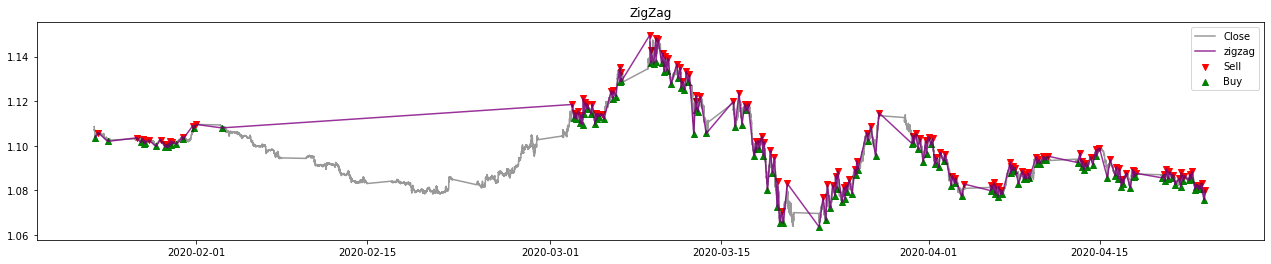

In [58]:
%%time
PEAK,VALLEY = zigzag(df,_deviation, _backstep, _depth)
df['BackHi_pic'] = PEAK
df['BackLo_val'] = VALLEY

In [35]:
##### Retracement
df = ret_hilo(df,0.618,0.01,0,0)

100%|██████████| 18533/18533 [00:01<00:00, 11465.76it/s]


In [36]:
##### FiboStoch
df = Fibo_Stoch(df)

100%|██████████| 18533/18533 [00:25<00:00, 715.10it/s]


In [37]:
%%time
##### Test Bedi'avad du PEAK/VALLEY pour déterminer les range target et le zigzag qu'on veut prédire (Saute la cellule d'après et joue avec le BT pour comprendre)
df['Signal'] = np.where(\
                            (df.BackLo_val == 1),1,\
                                                np.where(\
                                                            (df.BackHi_pic == 1),-1,0)
    )

CPU times: user 2.6 ms, sys: 735 µs, total: 3.33 ms
Wall time: 2.68 ms


In [38]:
df['STOCH'] = ((df.Close - df.Low.rolling(14).min()) / (df.High.rolling(14).max() - df.Low.rolling(14).min()))*100

In [39]:
%%time
df['Signal'] = np.where(\
    ((df.FiboStoch < 10)&(df.FiboStoch.shift(1) > 10)&(df.BuyRet == 1)),1,\
        np.where(\
            ((df.FiboStoch > 90)&(df.FiboStoch.shift(1) < 90)&(df.SellRet == 1)),-1,0)
    )

CPU times: user 4.8 ms, sys: 1.57 ms, total: 6.37 ms
Wall time: 5.37 ms


In [40]:
%%time
df['Signal'] = np.where(\
    ((df.STOCH < 10)&(df.STOCH.shift(1) > 10)&(df.BuyRet == 1)),1,\
        np.where(\
            ((df.STOCH > 90)&(df.STOCH.shift(1) < 90)&(df.SellRet == 1)),-1,0)
    )

CPU times: user 5.2 ms, sys: 1.99 ms, total: 7.19 ms
Wall time: 7.97 ms


In [55]:
_nb_bougie_exit = 20000
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 0
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.001
_exposure = 10
_size = 50000
_sl = 0.004
bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-09 15:22:30.386251

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 18390/18390 [00:03<00:00, 6027.42it/s]
(pas de duration)
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  0 !. En  10   transactions.
 
Nbre de winners : 0 
 
Nbre de loosers : 0 
Temps d'excution du BT 0:00:09.302484
 EUR/USD  results 
 Tested Period 2020-01-23 16:00:00  à 2020-04-23 16:00:00 
 Total Number of trades 10 
Started Cash : 50000
P&L in currency:  0$ 
P&L in %:  0.0% 
Average trade duration NA
# Winners  0
# Loosers  0
Cumulated gains 0
Cumulated losses 0
 PROFIT FACTOR :  nan 
 Winners Ratio  :None 
Average Winners 0.0
Average Loosers 0.0
Average pnl 0.0
% Average Winners 0.0
% Average Loosers 0.0
% Average pnl 0.0
Number of opened trades 10
Number of closed trades 0


ValueError: max() arg is an empty sequence

In [13]:
from multiclass_svm import modelize
from sklearn.preprocessing import MinMaxScaler

In [14]:
_model = 'muticlass_svm'
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
df_2 = df_2.drop(['Peak','Valley','BackHi_pic','BackLo_val'],axis=1)
df_2 = df_2.dropna()
df_2.loc[:, df_2.columns != 'Signal'] = scaler.fit_transform(df_2.loc[:, df_2.columns != 'Signal'].values) 
modelize(df.dropna(),x,_model)

 Multi class Support Vector Machine pour  EUR/USD 
Modèle : muticlass_svm
COMPUTING
Signaux Counter({0: 18312, 1: 45, -1: 33})
 Multiclass pour  EUR/USD 

Achat - Accuracy : 99.57 %
Achat - Precision : 99.57 %
Achat - Recall : 99.57 %
Achat - F-measure: : 99.57 % 


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        23
           0       1.00      1.00      1.00     12818
           1       0.00      0.00      0.00        32

    accuracy                           1.00     12873
   macro avg       0.33      0.33      0.33     12873
weighted avg       0.99      1.00      0.99     12873

[[    0    23     0]
 [    0 12818     0]
 [    0    32     0]]


 Joblib Model  JOBLIB/muticlass_svm/SaveEURUSDm5.sav  dumped to disk 


()

In [68]:
%%time
_year_bottom = pd.to_datetime('2020-04-15 16:00:00')
_year_top = pd.to_datetime('2020-04-23 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

CPU times: user 4.64 ms, sys: 7.19 ms, total: 11.8 ms
Wall time: 10.6 ms


In [80]:
_deviation = 0.1
_backstep = 3 # 3
_depth = 12 # 10

##### calcul du return sur backstep bougies : (actuel - initial) / initial

##### Calcul des max et des min sur les RetHiLo et les RetLoHi sur la fenêtre _backstep et répondant à l'amplitude _deviation
try:
    ##### On fixe la date en index sous forme de Timestamp
    df.set_index(pd.to_datetime(df.Date),drop=True,inplace=True)

    ###### On drop les colonnes inutiles car drop=True bug
    df = df.drop(['Date','Total'],axis=1)
except:
    pass

df['Peak'] = np.where(df.High == df.rolling(_backstep).High.max(),1,0)
df['Valley'] = np.where(df.Low == df.rolling(_backstep).Low.min(),1,0)

PEAK = []
VALLEY = []
_pic = 0
_val = 1
_idx = 0
_locked = 0
_sos = 0

for i in tqdm(range(0,len(df))):

    if df.Valley[i] == 1 or df.Peak[i] == 1:
        _locked += 1

    if df.Valley[i] == 1 and _val == 1 and df.Low[i] <= df.Low[i:i+_depth].min() and _idx==0:
        VALLEY.append(1)
        PEAK.append(0)
        _val = 0
        _pic = 1
        _idx = i
        _locked = 0
    
    elif df.Peak[i] == 1 and _pic == 1 and df.High[i] >= df.High[i:i+_depth].max() and _idx==0:
        VALLEY.append(0)
        PEAK.append(1)
        _pic = 0
        _val = 1
        _idx = i
        _locked = 0

    elif df.Valley[i] == 1 and _val == 1 and df.Low[i] <= df.Low[i:i+_depth].min() and ((df.Low[i] - df.High[_idx]) / df.High[_idx]) <= - _deviation:#*100
        VALLEY.append(1)
        PEAK.append(0)
        _val = 0
        _pic = 1
        _idx = i
        _locked = 0
    
    elif df.Peak[i] == 1 and _pic == 1 and df.High[i] >= df.High[i:i+_depth].max() and ((df.High[i] - df.Low[_idx]) / df.Low[_idx]) >= _deviation:#*100
        VALLEY.append(0)
        PEAK.append(1)
        _pic = 0
        _val = 1
        _idx = i
        _locked = 0

    '''while _locked >= 10 :
        print('\r_sos ',_sos,end='')
        _sos += 20
        if df.Valley[i] == 1 and _val == 1 and df.Low[i] <= df.Low[i:i+_depth+_sos].min() and ((df.Low[i] - df.High[_idx]) / df.High[_idx]) <= - _deviation:
            VALLEY.append(1)
            PEAK.append(0)
            _val = 0
            _pic = 1
            _idx = i
            _locked = 0

        elif df.Peak[i] == 1 and _pic == 1 and df.High[i] >= df.High[i:i+_depth+_sos].max() and ((df.High[i] - df.Low[_idx]) / df.Low[_idx]) >= _deviation:#*100
            VALLEY.append(0)
            PEAK.append(1)
            _pic = 0
            _val = 1
            _idx = i
            _locked = 0
        else:
            VALLEY.append(0)
            PEAK.append(0)
            continue'''
        


    else :
        VALLEY.append(0)
        PEAK.append(0)


df['Peak'] = PEAK
df['Valley'] = VALLEY

df_zigzag = pd.DataFrame()

print('Il y a ',sum(VALLEY),'signaux VALLEY, ',sum(PEAK),'signaux PEAK, et ',len(df)-sum(PEAK)-sum(VALLEY),' signaux sans rien' )

df_zigzag['PeakValley'] = pd.concat([df.Peak, df.Valley], axis=0, ignore_index=False, sort=True)
df_zigzag['Close'] = pd.concat([df.High, df.Low], axis=0, ignore_index=False, sort=True)
df_zigzag = df_zigzag[df_zigzag.PeakValley==1]
# Sort peak and valley datapoints by date.
df_zigzag = df_zigzag.sort_index()



plt.figure(figsize=(22,4))
plt.title('ZigZag')
plt.plot(df.Close,color='black',alpha=0.4,label="Close")
#plt.plot(df.High,color='orange',alpha=0.3,label="High")
#plt.plot(df.Low,color='blue',alpha=0.3,label="Low")
plt.scatter(x=df[df.Peak==1].index,y=df[df.Peak==1].High,color='red',marker='v',label="Sell")
plt.scatter(x=df[df.Valley==1].index,y=df[df.Valley==1].Low,color='green',marker='^',label="Buy")
# Plot zigzag trendline.
plt.plot(df_zigzag.index.values, df_zigzag['Close'].values,color='purple', label="zigzag",alpha=0.8)
plt.legend()

_sos  378140


KeyboardInterrupt: 

In [75]:
len(VALLEY),len(PEAK),len(df)

(30, 30, 1705)